### questions from TJC
 - can we get estimates/error bars from wihtin individuals when it comes to dating admixture
 - can we get individual admixture ages per country (maybe a boxplot).
 - test for selection consider using the same ones from the previous paper and/or iHS.

# Ancestry *S.haematobium* vs. *S. bovis* across Africa (SCAN)

Neal Platt 2021

# Prep envrinoment and data for analyses

use the `sch_hae_scan/envs/jupyterlab_ancestry` conda environment

In [3]:
import os
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.pyplot import figure
from tqdm import tqdm
from pathlib import Path
from itertools import combinations 
from scipy.ndimage.filters import median_filter
from IPython.display import Image 
import glob
import pybedtools
import gffutils
import vcf
import itertools
from scipy.stats import linregress

/tmp/ipykernel_48859/1735971683.py:11: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter


In [4]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)
os.chdir(results_dir)

## Get sample info

In [5]:
sample_info_df = pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir))

In [6]:
sample_info_df

,admera_id,barcode_label_ID,library_id,sample_name,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon?
0,19047FL-14-02-03,MCF03050E0612,na,sha_angola_cota_57,SRR11907442,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
1,19047FL-14-02-04,MCF03050E0613,na,sha_angola_cota_58,SRR11907441,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
2,19047FL-14-02-05,MCF03050E0614,na,sha_angola_cota_59,SRR11907440,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
3,19047FL-14-02-06,MCF03050E0615,na,sha_angola_icau_60,SRR11907439,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
4,19047FL-14-02-07,MCF03050E0615,na,sha_angola_icau_61,SRR11907438,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,na,na,na,sh_egypt_SRR433862,SRR433862,s_haematobium,egypt,na,na,haematobium,Rey_2019,genome,NaN,NaN
445,na,na,na,sh_gambia_SRR13579872,SRR13579872,s_haematobium,gambia,na,na,haematobium,Rey_2019,genome,NaN,NaN
446,na,na,na,sh_ivorycoast_SRR13579866,SRR13579866,s_haematobium,cote_d_ivoire,na,na,haematobium,Rey_2019,genome,NaN,NaN
447,na,na,na,sh_madagascar_SRR13579871,SRR13579871,s_haematobium,madagascar,na,na,haematobium,Rey_2019,genome,NaN,NaN


## Read in data and get allele counts

In [6]:
#read in the vcf file
filtered_callset=allel.read_vcf('post_phase_filtering/chrs_unrelated.vcf')

In [7]:
#get relevant info
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [7]:
#read in pca df since it has species ids and kmeans labels
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
pca_df["country"] = pca_df["country"].astype(str)

### Species

In [9]:
#get species idxs
sp_idxs = {}
sp_acs  = {}

for sp in tqdm(["s_bovis", "s_haematobium"]):
    
    #find indecies for each sample from that species
    names = pca_df.loc[pca_df["pca_species"] ==  sp, "sample_name"]
    sp_idxs[sp]=np.in1d(samples, names).nonzero()[0]

    #get allele counts for each species
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.33s/it]


In [10]:
#add outgroups
s_guineensis   = "guineensis_saotome_ERR119612"
s_intercalatum = "intercalatum_drcongo_ERR119613"
s_margrebowiei = "margrebowiei_zambia_ERR310940"
s_matthei      = "matthei_zambia_ERR103051"

outgroups=[s_guineensis, s_intercalatum, s_margrebowiei, s_matthei]


In [11]:
for sp in tqdm(outgroups):
    sp_idxs[sp] = [list(samples).index(sp)]
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.27s/it]


### Kmeans group

In [12]:
#get species idxs
k_pop_idxs = {}
k_pop_acs  = {}

for k in tqdm(pca_df["kmeans_label"].unique()):
    
    #find indecies for each sample per k population
    ks = pca_df.loc[pca_df["kmeans_label"] ==  k, "sample_name"]
    k_pop_idxs[k]=np.in1d(samples, ks).nonzero()[0]
    
    #get allele counts for k group
    k_pop_acs[k] = gt.count_alleles(subpop=k_pop_idxs[k])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:33<00:00,  4.78s/it]


In [13]:
major_acs={"sh_nw":          k_pop_acs["sh_nw"],
           "sh_se":          k_pop_acs["sh_se"],
           "sb":             k_pop_acs["sb"] ,
           "sh":             sp_acs["s_haematobium"],
           "s_guineensis":   sp_acs["guineensis_saotome_ERR119612"],
           "s_intercalatum": sp_acs["intercalatum_drcongo_ERR119613"],
           "s_margrebowiei": sp_acs["margrebowiei_zambia_ERR310940"],
           "s_matthei":      sp_acs["matthei_zambia_ERR103051"]  }

# Ancestry and introgression

## F3

The expected ouptuts from F3 via scikit-allel

```
f3 = Estimated value of the statistic using all data.
se = Estimated standard error.
z  = Z-score (number of standard errors from zero).
vb = Value of the statistic in each block.
vj = Values of the statistic from block-jackknife resampling
```


In [15]:
Path("{}/f3".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/f3".format(results_dir))

In [16]:
#f3, se, z, vb_nw, vj
allel.average_patterson_f3(major_acs["sh_nw"], major_acs["sb"], major_acs["sh_se"], 500, normed=True)

(-0.12849096146813438,
 0.0008214325668359705,
 -156.42301834106897,
 array([ 0.36347718, -0.05698381, -0.17468422, ...,  0.06119387,
         0.10767411, -0.17292173]),
 array([-0.128501  , -0.12849249, -0.12849033, ..., -0.12849788,
        -0.12849754, -0.12849083]))

In [17]:
#f3, se, z, vb_nw, vj
allel.average_patterson_f3(major_acs["sh_se"], major_acs["sb"], major_acs["sh_nw"], 500, normed=True)

/master/nplatt/anaconda3/envs/ancestry/lib/python3.9/site-packages/allel/stats/admixture.py:38: RuntimeWarning: invalid value encountered in divide
  x = (ac[:, 0] * ac[:, 1]) / (an * (an - 1))


(0.6293945987644662,
 0.005353228329136952,
 117.5729036885556,
 array([0.06376649, 0.25631196, 0.45759006, ..., 0.04232105, 0.06545219,
        0.32414657]),
 array([0.62943305, 0.62940998, 0.62939858, ..., 0.62944592, 0.62943238,
        0.62939841]))

These results show that there is admixture in the NW population but not the SE population since F3 is sig negative

## D: ABBA BABA

The expected ouptuts from F3 via scikit-allel


```
d = Estimated value of the statistic using all data.
se = Estimated standard error.
z = Z-score (number of standard errors from zero).
vb = Value of the statistic in each block.
vj = Values of the statistic from block-jackknife resampling.
```

https://www.genetics.org/content/192/3/1065

In [51]:
Path("{}/abba_baba".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/abba_baba".format(results_dir))

In [19]:
len(vb)

14327

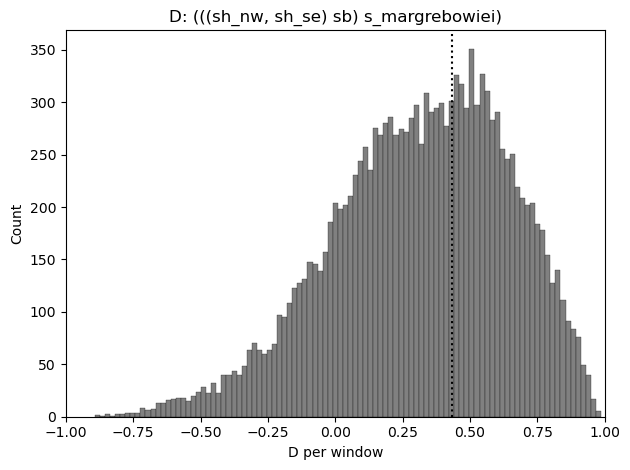

In [17]:
a="sh_nw"
b="sh_se"
c="sb"
o="s_margrebowiei"

d, se, z, vb, vj = allel.average_patterson_d(major_acs[a], major_acs[b], major_acs[c], major_acs[o], 2500)

plt.hist(vb, bins=100, color="grey",  edgecolor="black", linewidth=0.2)
plt.xlim([-1,1])
plt.axvline(d, color = 'black', linestyle = ':')
plt.ylabel("Count".format(k))
plt.xlabel("D per window")
plt.title("D: ((({}, {}) {}) {})".format(a,b,c,o))
plt.tight_layout()

plt.show()

In [18]:
print(f"D={d} (abba baba; SE={se})")

D=0.43358730465095385 (abba baba; SE=0.005734084923535246)


In [52]:
d_df=pd.DataFrame(columns=["chrom", "start", "stop", "d"])


major_chroms=uniq_chroms[0:8]

for chrom in tqdm(major_chroms):
    chrom_pos = poss[chroms == chrom]

    aca=major_acs["sh_nw"][chroms == chrom]
    acb=major_acs["sh_se"][chroms == chrom]
    acc=major_acs["sb"][chroms == chrom]
    acd=major_acs["s_margrebowiei"][chroms == chrom]
    
    try:
        
        d = allel.moving_patterson_d(aca, acb, acc, acd, 500)
        starts = list(chrom_pos[0::500])
        stops = list(chrom_pos[499::500])
        tmp_chrs = [chrom] * len(d)
        

        #add info to a df
        chr_df=pd.DataFrame([tmp_chrs, starts, stops, d]).T
        chr_df.columns=["chrom", "start", "stop", "d"]

        d_df=pd.concat([d_df, chr_df])

    except:
        print(f"An exception occurred: {chrom}")
        break

   
    d_df["n_snps"] = 500

    #save df to a csv
    d_df.to_csv(f"patterson_d.csv", index=False, sep=",")

  0%|                                                                                                                                                                                                                  | 0/8 [00:00<?, ?it/s]/master/nplatt/anaconda3/envs/ancestry/lib/python3.9/site-packages/allel/stats/admixture.py:297: RuntimeWarning: invalid value encountered in divide
  d = num_sum / den_sum
 12%|█████████████████████████▎                                                                                                                                                                                | 1/8 [00:06<00:42,  6.10s/it]/master/nplatt/anaconda3/envs/ancestry/lib/python3.9/site-packages/allel/stats/admixture.py:297: RuntimeWarning: invalid value encountered in divide
  d = num_sum / den_sum
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [69]:
#d_df = d_df.dropna().reset_index()
d_df['z_score'] = d_df['d'] / d_df['d'].std()

d_df.to_csv(f"patterson_d.csv", index=False, sep=",")

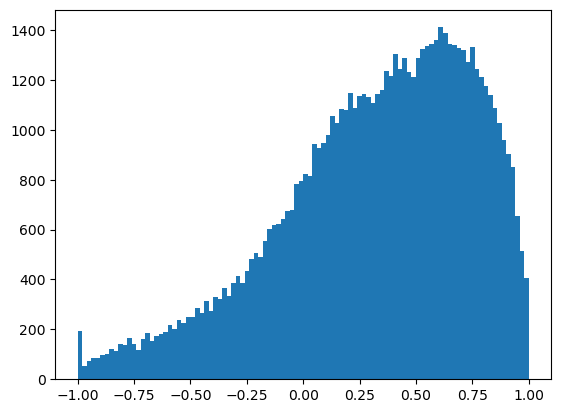

In [54]:
plt.hist(d_df["d"], bins=100)
plt.show()

In [50]:
d_df.loc[(d_df["chrom"] == "NC_067199.1") &
           (d_df["start"] >= 28585000.0) &
           (d_df["stop"] <= 28784000.0),
          "d"].median()




-0.26602107741642483

In [ ]:
allel.moving_patterson_d(aca, acb, acc, acd, size, start=0, stop=None, step=None)

## Rfmix

In [9]:
Path("{}/rfmix".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/rfmix".format(results_dir))

### Prepping and running rfmix

In [24]:
%%bash

#make sample map
# tab file with references and their "ancestry"
awk '{print $1"\tSb"}' /master/nplatt/sch_hae_scan/results/admixture/sb_ref.list >ref_sample.map
awk '{print $1"\tSh"}' /master/nplatt/sch_hae_scan/results/admixture/sh_ref.list >>ref_sample.map

#get ref vcf 
cut -f1  ref_sample.map >ref_sample.list

In [25]:
%%bash

#get a vcf of the ref samples
conda run -n ancestry --cwd . --live-stream \
    vcftools \
        --vcf ../post_phase_filtering/chrs_unrelated.vcf \
        --keep ref_sample.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >ref.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../phasing/beagle.vcf
	--keep ref_sample.list
	--recode-INFO-all
	--recode
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 51 out of 171 Individuals
Outputting VCF file...
After filtering, kept 38124411 out of a possible 38124411 Sites
Run Time = 1941.00 seconds


In [15]:
%%bash

#get vcf with only the query samples (exclude ref samples and outgroups)

echo -e "guineensis_saotome_ERR119612\nintercalatum_drcongo_ERR119613\nmargrebowiei_zambia_ERR310940\nmatthei_zambia_ERR103051">outgroup.list
cat ref_sample.list outgroup.list >remove.list

conda run -n ancestry --cwd . --live-stream \
    vcftools \
        --vcf ../post_phase_filtering/chrs_unrelated.vcf \
        --remove remove.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >query.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../post_phase_filtering/chrs_unrelated.vcf
	--remove remove.list
	--recode-INFO-all
	--recode
	--stdout

Excluding individuals in 'exclude' list
After filtering, kept 111 out of 166 Individuals
Outputting VCF file...
After filtering, kept 35817757 out of a possible 35817757 Sites
Run Time = 2036.00 seconds


In [16]:
%%bash

#make the genetic map
cut -f1,2 query.vcf | grep -v "#" | awk '{print $0"\t"$2/287000}' >genetic.map

# get a list of all scaffolds
cut -f1 genetic.map | sort | uniq >scaffs.list

In [17]:
%%bash 

#submit rfmix jobs to the cluster

for SCAFF in $(cat scaffs.list); do
#for SCAFF in NC_067196.1; do

    mkdir ${SCAFF}
    
    CMD="conda run -n ancestry --cwd . --live-stream \
        rfmix \
            --query-file=query.vcf \
            --reference-file=ref.vcf \
            --sample-map=ref_sample.map \
            --genetic-map=genetic.map \
            --output-basename=${SCAFF}/${SCAFF} \
            --chromosome=\"${SCAFF}\" \
            --n-threads=64 \
            --random-seed=12345"

        QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 64 -N ${SCAFF} -o ${SCAFF}.log"

        echo $CMD | $QSUB
done

Your job 956574 ("NC_067195.1") has been submitted
Your job 956575 ("NC_067196.1") has been submitted
Your job 956576 ("NC_067197.1") has been submitted
Your job 956577 ("NC_067198.1") has been submitted
Your job 956578 ("NC_067199.1") has been submitted
Your job 956579 ("NC_067200.1") has been submitted
Your job 956580 ("NC_067201.1") has been submitted
Your job 956581 ("NC_067202.1") has been submitted


### Iniital processing of RFMIX results

In [167]:
rf_files = glob.glob("NC_067*.1/NC_067*.1.msp.tsv")

In [168]:
chr_aliases = { "NC_067195.1": "chrzw",
                "NC_067196.1": "chr1",
                "NC_067197.1": "chr2",
                "NC_067198.1": "chr3",
                "NC_067199.1": "chr4",
                "NC_067200.1": "chr5",
                "NC_067201.1": "chr6",
                "NC_067202.1": "chr7" }

In [169]:
rfmix_df=pd.DataFrame()

for rf_file in tqdm(rf_files):
    scaff=rf_file.split("/")[0]
    tmp_df = pd.read_csv(rf_file, delimiter="\t", header=1)
    rfmix_df=pd.concat([tmp_df, rfmix_df], axis=0)
    del(tmp_df)
    
rfmix_df = rfmix_df.rename(columns={"#chm": "chrom", 
                                    "n snps": "n_snps",
                                    "spos": "s_pos",
                
                                    "epos": "e_pos",
                                    "sgpos": "s_gpos",
                                    "egpos": "e_gpos" })
rfmix_df.reset_index(inplace=True, drop=True)
rfmix_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.24it/s]


,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,Sb_NG_au_1.2.0,Sb_NG_au_1.2.1,Sb_NG_au_2.13.0,Sb_NG_au_2.13.1,...,ssp_niger_libore_166.0,ssp_niger_libore_166.1,ssp_niger_libore_167.0,ssp_niger_libore_167.1,ssp_niger_libore_168.0,ssp_niger_libore_168.1,ssp_niger_libore_169.0,ssp_niger_libore_169.1,ssp_zambia_kafue_71.0,ssp_zambia_kafue_71.1
0,NC_067196.1,124225,212192,0.43,0.74,1302,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,NC_067196.1,212192,289797,0.74,1.01,860,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,NC_067196.1,289797,302958,1.01,1.06,645,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,NC_067196.1,302958,623463,1.06,2.17,2980,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,NC_067196.1,623463,625997,2.17,2.18,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1


In [ ]:
rfmix_df.to_csv("rfmix_df.csv", index=False)

In [7]:
rfmix_df=pd.read_csv("rfmix_df.csv")
rfmix_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,Sb_NG_au_1.2.0,Sb_NG_au_1.2.1,Sb_NG_au_2.13.0,Sb_NG_au_2.13.1,...,ssp_niger_libore_166.0,ssp_niger_libore_166.1,ssp_niger_libore_167.0,ssp_niger_libore_167.1,ssp_niger_libore_168.0,ssp_niger_libore_168.1,ssp_niger_libore_169.0,ssp_niger_libore_169.1,ssp_zambia_kafue_71.0,ssp_zambia_kafue_71.1
0,NC_067196.1,124225,212192,0.43,0.74,1302,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,NC_067196.1,212192,289797,0.74,1.01,860,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,NC_067196.1,289797,302958,1.01,1.06,645,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,NC_067196.1,302958,623463,1.06,2.17,2980,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,NC_067196.1,623463,625997,2.17,2.18,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1


In [ ]:
samples=rfmix_df.columns[6:]

In [35]:
bp_df=rfmix_df.copy()

bp_sizes=[]
for index, row in tqdm(bp_df.iterrows()):
    size=row["e_pos"] - row["s_pos"]
    for sample in samples:
        if bp_df.loc[index, sample] == 1:
            bp_df.loc[index, sample] = size
bp_df

39477it [06:59, 94.08it/s] 


,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,Sb_NG_au_1.2.0,Sb_NG_au_1.2.1,Sb_NG_au_2.13.0,Sb_NG_au_2.13.1,...,ssp_niger_libore_166.0,ssp_niger_libore_166.1,ssp_niger_libore_167.0,ssp_niger_libore_167.1,ssp_niger_libore_168.0,ssp_niger_libore_168.1,ssp_niger_libore_169.0,ssp_niger_libore_169.1,ssp_zambia_kafue_71.0,ssp_zambia_kafue_71.1
0,NC_067196.1,124225,212192,0.43,0.74,1302,0,87967,0,0,...,0,0,0,0,0,0,0,0,87967,87967
1,NC_067196.1,212192,289797,0.74,1.01,860,0,77605,0,0,...,0,0,0,0,0,0,0,0,77605,77605
2,NC_067196.1,289797,302958,1.01,1.06,645,0,13161,0,0,...,0,0,0,0,0,0,0,0,13161,13161
3,NC_067196.1,302958,623463,1.06,2.17,2980,0,0,0,0,...,0,0,0,0,0,0,0,0,320505,320505
4,NC_067196.1,623463,625997,2.17,2.18,25,0,0,0,0,...,0,0,0,0,0,0,0,0,2534,2534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0,0,0,0,...,2696,2696,0,2696,2696,2696,2696,2696,2696,2696
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0,0,0,0,...,69,69,0,69,69,69,69,69,69,69
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0,0,0,0,...,1359,1359,0,1359,1359,1359,1359,1359,1359,1359
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0,0,0,0,...,647,647,0,647,647,647,647,647,647,647


In [36]:
bp_df.to_csv("bp_df.csv", header=True, index=False, sep=",")

### Percent SB per individual

In [256]:
perc_indv_bov_df = pd.DataFrame(bp_df[samples].sum(axis=0), columns=["bp_haem"])

perc_indv_bov_df["perc_sh"] = perc_indv_bov_df["bp_haem"]/rfmix_genome_size
perc_indv_bov_df["perc_bov"] = 1-(perc_indv_bov_df["perc_sh"])


#perc_indv_bov_df["perc_bov"] = perc_indv_bov_df["bp_haem"]/892_082_149

# #perc_indv_bov_df["perc_bov"] = 1-(perc_indv_bov_df["bp_haem"]/(295_873_745))
perc_indv_bov_df["rfmix_id"] = perc_indv_bov_df.index

perc_indv_bov_df["hap"] = [x.split(".")[-1] for x in perc_indv_bov_df.index]
perc_indv_bov_df["sample_id"] = [".".join(x.split(".")[:-1]) for x in perc_indv_bov_df.index]
perc_indv_bov_df

perc_indv_bov_df = perc_indv_bov_df[['sample_id', 'hap', "rfmix_id", 'bp_haem', 'perc_sh', 'perc_bov']]
perc_indv_bov_df.reset_index(inplace=True, drop=True)


perc_indv_bov_df = pd.merge(left  = pca_df[["sample_name", "kmeans_label"]],
                            right = perc_indv_bov_df,
                            left_on = "sample_name",
                            right_on = "sample_id",
                            how = "right").drop(columns=["sample_name"])

perc_indv_bov_df = perc_indv_bov_df[['sample_id', 'hap', "rfmix_id", "kmeans_label", 'bp_haem', 'perc_sh', 'perc_bov']]

perc_indv_bov_df.to_csv("perc_indv.csv", sep=",", index=False)

perc_indv_bov_df

,sample_id,hap,rfmix_id,kmeans_label,bp_haem,perc_sh,perc_bov
0,Sb_NG_au_1.2,0,Sb_NG_au_1.2.0,sb,207981,0.000531,0.999469
1,Sb_NG_au_1.2,1,Sb_NG_au_1.2.1,sb,246466,0.000629,0.999371
2,Sb_NG_au_2.13,0,Sb_NG_au_2.13.0,sb,0,0.000000,1.000000
3,Sb_NG_au_2.13,1,Sb_NG_au_2.13.1,sb,70387,0.000180,0.999820
4,Sb_NG_be_1.5,0,Sb_NG_be_1.5.0,sb,13021,0.000033,0.999967
...,...,...,...,...,...,...,...
217,ssp_niger_libore_168,1,ssp_niger_libore_168.1,sh_nw,361466338,0.922278,0.077722
218,ssp_niger_libore_169,0,ssp_niger_libore_169.0,sh_nw,363656854,0.927867,0.072133
219,ssp_niger_libore_169,1,ssp_niger_libore_169.1,sh_nw,364577156,0.930216,0.069784
220,ssp_zambia_kafue_71,0,ssp_zambia_kafue_71.0,sh_se,391685246,0.999382,0.000618


In [17]:
perc_indv_bov_df = pd.read_csv("perc_indv.csv")
perc_indv_bov_df

,sample_id,hap,rfmix_id,kmeans_label,bp_haem,perc_sh,perc_bov
0,Sb_NG_au_1.2,0,Sb_NG_au_1.2.0,sb,207981,0.000531,0.999469
1,Sb_NG_au_1.2,1,Sb_NG_au_1.2.1,sb,246466,0.000629,0.999371
2,Sb_NG_au_2.13,0,Sb_NG_au_2.13.0,sb,0,0.000000,1.000000
3,Sb_NG_au_2.13,1,Sb_NG_au_2.13.1,sb,70387,0.000180,0.999820
4,Sb_NG_be_1.5,0,Sb_NG_be_1.5.0,sb,13021,0.000033,0.999967
...,...,...,...,...,...,...,...
217,ssp_niger_libore_168,1,ssp_niger_libore_168.1,sh_nw,361466338,0.922278,0.077722
218,ssp_niger_libore_169,0,ssp_niger_libore_169.0,sh_nw,363656854,0.927867,0.072133
219,ssp_niger_libore_169,1,ssp_niger_libore_169.1,sh_nw,364577156,0.930216,0.069784
220,ssp_zambia_kafue_71,0,ssp_zambia_kafue_71.0,sh_se,391685246,0.999382,0.000618


In [141]:
perc_indv_bov_df.loc[perc_indv_bov_df["kmeans_label"] == "sh_nw", "perc_bov"].min()

0.0397879457182258

In [142]:
perc_indv_bov_df.loc[perc_indv_bov_df["kmeans_label"] == "sh_nw", "perc_bov"].max()

0.224530650717958

In [143]:
perc_indv_bov_df["kmeans_label"].value_counts()/2

sh_nw    82.0
sh_se    21.0
sb        8.0
Name: kmeans_label, dtype: float64

In [144]:
perc_indv_bov_df.groupby(by=["kmeans_label"]).mean()

,hap,bp_haem,perc_sh,perc_bov
kmeans_label,,,,
sb,0.5,1.085675e+06,0.002770,0.997230
sh_nw,0.5,3.629432e+08,0.926047,0.073953
sh_se,0.5,3.917684e+08,0.999594,0.000406


In [262]:
perc_indv_bov_df.groupby(by=["kmeans_label"]).median()

,hap,bp_haem,perc_sh,perc_bov
kmeans_label,,,,
sb,0.5,248003.0,0.000633,0.999367
sh_nw,0.5,364253160.0,0.929389,0.070611
sh_se,0.5,391844170.0,0.999787,0.000213


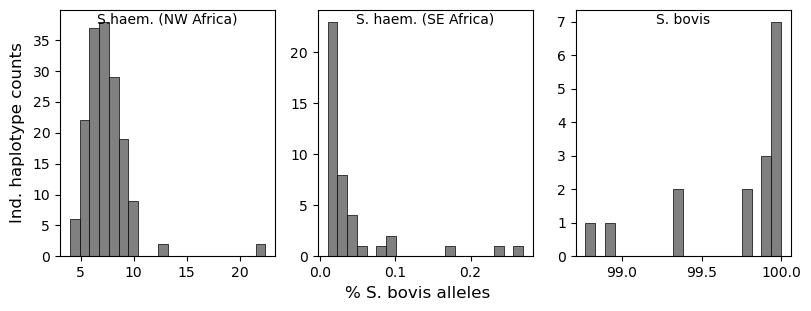

In [263]:
fig, (ax_nw, ax_se, ax_sb) = plt.subplots(nrows=1, ncols=3, figsize=(8,3))

sb = perc_indv_bov_df.loc[perc_indv_bov_df["kmeans_label"] == "sb", "perc_bov"]
nw = perc_indv_bov_df.loc[perc_indv_bov_df["kmeans_label"] == "sh_nw", "perc_bov"]
se = perc_indv_bov_df.loc[perc_indv_bov_df["kmeans_label"] == "sh_se", "perc_bov"]

ax_nw.hist(nw*100, bins=20, alpha=1, label="S.h. (NW)", color='grey', edgecolor="black", linewidth=0.5)
ax_nw.set_title("S.haem. (NW Africa)", fontsize=10, y=1.0, pad=-10)

ax_se.hist(se*100, bins=20, alpha=1, label="S.h. (SE)", color='grey', edgecolor="black", linewidth=0.5)
ax_se.set_title("S. haem. (SE Africa)", fontsize=10, y=1.0, pad=-10)

ax_sb.hist(sb*100, bins=20, alpha=1, label="S. bovis", color='grey', edgecolor="black", linewidth=0.5)
ax_sb.set_title("S. bovis", fontsize=10, y=1.0, pad=-10)


fig.text(0.00, 0.25, 'Ind. haplotype counts', ha='center', rotation='vertical', fontsize=12)
fig.text(0.5, -0.01, '% S. bovis alleles', ha='center', fontsize=12)
fig.tight_layout()
plt.savefig("percent_bovis_per_indiv.svg")
plt.savefig("percent_bovis_per_indiv.png", dpi=300)
plt.show()

### percent sb across the genome

In [153]:
rfmix_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,Sb_NG_au_1.2.0,Sb_NG_au_1.2.1,Sb_NG_au_2.13.0,Sb_NG_au_2.13.1,...,ssp_niger_libore_166.0,ssp_niger_libore_166.1,ssp_niger_libore_167.0,ssp_niger_libore_167.1,ssp_niger_libore_168.0,ssp_niger_libore_168.1,ssp_niger_libore_169.0,ssp_niger_libore_169.1,ssp_zambia_kafue_71.0,ssp_zambia_kafue_71.1
0,NC_067196.1,124225,212192,0.43,0.74,1302,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,NC_067196.1,212192,289797,0.74,1.01,860,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,NC_067196.1,289797,302958,1.01,1.06,645,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,NC_067196.1,302958,623463,1.06,2.17,2980,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,NC_067196.1,623463,625997,2.17,2.18,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1


In [154]:
rfmix_k_idxs={}    
for k_label in ["sb", "sh_nw", "sh_se"]:
    idxs = list(perc_indv_bov_df.loc[perc_indv_bov_df["kmeans_label"] == k_label]["rfmix_id"])
    rfmix_k_idxs[k_label] = idxs


In [162]:
sb_freq = rfmix_df[ rfmix_k_idxs["sb"]    ].sum(axis=1)
nw_freq = rfmix_df[ rfmix_k_idxs["sh_nw"] ].sum(axis=1)
se_freq = rfmix_df[ rfmix_k_idxs["sh_se"] ].sum(axis=1)

site_info = rfmix_df.iloc[: ,0:6]

df  = pd.concat([site_info, sb_freq, nw_freq, se_freq], axis=1)
df.columns=["chrom", "s_pos", "e_pos", "s_gpos", "e_gpos", "n_snps", "n_sb", "n_sh_nw", "n_sh_se"]          

df["perc_sb"]    = 1-(df["n_sb"]/len(rfmix_k_idxs["sb"]))
df["perc_sh_nw"] = 1-(df["n_sh_nw"]/len(rfmix_k_idxs["sh_nw"]))
df["perc_sh_se"] = 1-(df["n_sh_se"]/len(rfmix_k_idxs["sh_se"]))

df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se
0,NC_067196.1,124225,212192,0.43,0.74,1302,1,29,42,0.9375,0.823171,0.0
1,NC_067196.1,212192,289797,0.74,1.01,860,2,28,42,0.8750,0.829268,0.0
2,NC_067196.1,289797,302958,1.01,1.06,645,3,28,42,0.8125,0.829268,0.0
3,NC_067196.1,302958,623463,1.06,2.17,2980,2,28,42,0.8750,0.829268,0.0
4,NC_067196.1,623463,625997,2.17,2.18,25,1,28,42,0.9375,0.829268,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,1,145,42,0.9375,0.115854,0.0
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,1,147,42,0.9375,0.103659,0.0
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,1,146,42,0.9375,0.109756,0.0
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,1,145,42,0.9375,0.115854,0.0


In [163]:
df.sort_values(by=["chrom", "s_pos"], axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
df.to_csv("rfmix_perc_bovis_genome.csv", sep=",", index=False)
df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se
0,NC_067195.1,14416,75442,0.05,0.26,582,0,156,42,1.0,0.048780,0.0
1,NC_067195.1,75442,106309,0.26,0.37,335,0,155,42,1.0,0.054878,0.0
2,NC_067195.1,106309,146168,0.37,0.51,465,0,154,42,1.0,0.060976,0.0
3,NC_067195.1,146168,156662,0.51,0.55,580,0,154,42,1.0,0.060976,0.0
4,NC_067195.1,156662,164518,0.55,0.57,885,0,155,42,1.0,0.054878,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067202.1,19335566,19381118,67.37,67.53,4950,0,159,42,1.0,0.030488,0.0
39473,NC_067202.1,19381118,19401743,67.53,67.60,2335,0,158,42,1.0,0.036585,0.0
39474,NC_067202.1,19401743,19427939,67.60,67.69,2290,0,159,42,1.0,0.030488,0.0
39475,NC_067202.1,19427939,19464116,67.69,67.82,1825,0,160,42,1.0,0.024390,0.0


In [8]:
df=pd.read_csv("rfmix_perc_bovis_genome.csv", sep=",")
df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se,x_start,x_end,color
0,NC_067195.1,14416,75442,0.05,0.26,582,0,156,42,1.0,0.048780,0.0,320428073,320489099,#7bade3
1,NC_067195.1,75442,106309,0.26,0.37,335,0,155,42,1.0,0.054878,0.0,320489099,320519966,#7bade3
2,NC_067195.1,106309,146168,0.37,0.51,465,0,154,42,1.0,0.060976,0.0,320519966,320559825,#7bade3
3,NC_067195.1,146168,156662,0.51,0.55,580,0,154,42,1.0,0.060976,0.0,320559825,320570319,#7bade3
4,NC_067195.1,156662,164518,0.55,0.57,885,0,155,42,1.0,0.054878,0.0,320570319,320578175,#7bade3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067202.1,19335566,19381118,67.37,67.53,4950,0,159,42,1.0,0.030488,0.0,317768034,317813586,#078d70
39473,NC_067202.1,19381118,19401743,67.53,67.60,2335,0,158,42,1.0,0.036585,0.0,317813586,317834211,#078d70
39474,NC_067202.1,19401743,19427939,67.60,67.69,2290,0,159,42,1.0,0.030488,0.0,317834211,317860407,#078d70
39475,NC_067202.1,19427939,19464116,67.69,67.82,1825,0,160,42,1.0,0.024390,0.0,317860407,317896584,#078d70


In [10]:
df.sort_values("perc_sh_nw")

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se,x_start,x_end,color
12486,NC_067197.1,25783410,25797452,89.84,89.89,1630,0,164,42,1.0000,0.0,0.0,121589960,121604002,#7bade3
7123,NC_067196.1,62491161,62576284,217.74,218.04,7125,0,164,42,1.0000,0.0,0.0,62491161,62576284,#078d70
7124,NC_067196.1,62576284,62583907,218.04,218.06,935,1,164,42,0.9375,0.0,0.0,62576284,62583907,#078d70
7125,NC_067196.1,62583907,62593693,218.06,218.10,830,0,164,42,1.0000,0.0,0.0,62583907,62593693,#078d70
7129,NC_067196.1,62635685,62639338,218.24,218.26,175,0,164,42,1.0000,0.0,0.0,62635685,62639338,#078d70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25093,NC_067200.1,1490386,1531077,5.19,5.33,2125,1,0,42,0.9375,1.0,0.0,247264663,247305354,#7bade3
25092,NC_067200.1,1382713,1490386,4.82,5.19,8650,2,0,42,0.8750,1.0,0.0,247156990,247264663,#7bade3
25091,NC_067200.1,1274153,1382713,4.44,4.82,755,1,0,42,0.9375,1.0,0.0,247048430,247156990,#7bade3
25090,NC_067200.1,1200435,1274153,4.18,4.44,1250,0,0,42,1.0000,1.0,0.0,246974712,247048430,#7bade3


In [12]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb

offsets=dict(zip(pos_df["contig"], pos_df["x_start"].astype(int)))
colors=dict(zip(pos_df["contig"], pos_df["color"].astype(str)))

x_start=[]
x_end=[]
c=[]

for index, row in df.iterrows():
    chrom = row["chrom"]
    
    offset=offsets[chrom]
    color = colors[chrom]
    
    x_start.append(row["s_pos"] + offset)
    x_end.append(row["e_pos"] + offset)

    c.append(color)
    
df["x_start"] = x_start
df["x_end"] = x_end
df["color"] = c

#df.to_csv(f"rfmix_perc_bovis_genome.csv", header=True, sep=",", index=False)
df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se,x_start,x_end,color
0,NC_067195.1,14416,75442,0.05,0.26,582,0,156,42,1.0,0.048780,0.0,320428073,320489099,#7bade3
1,NC_067195.1,75442,106309,0.26,0.37,335,0,155,42,1.0,0.054878,0.0,320489099,320519966,#7bade3
2,NC_067195.1,106309,146168,0.37,0.51,465,0,154,42,1.0,0.060976,0.0,320519966,320559825,#7bade3
3,NC_067195.1,146168,156662,0.51,0.55,580,0,154,42,1.0,0.060976,0.0,320559825,320570319,#7bade3
4,NC_067195.1,156662,164518,0.55,0.57,885,0,155,42,1.0,0.054878,0.0,320570319,320578175,#7bade3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067202.1,19335566,19381118,67.37,67.53,4950,0,159,42,1.0,0.030488,0.0,317768034,317813586,#078d70
39473,NC_067202.1,19381118,19401743,67.53,67.60,2335,0,158,42,1.0,0.036585,0.0,317813586,317834211,#078d70
39474,NC_067202.1,19401743,19427939,67.60,67.69,2290,0,159,42,1.0,0.030488,0.0,317834211,317860407,#078d70
39475,NC_067202.1,19427939,19464116,67.69,67.82,1825,0,160,42,1.0,0.024390,0.0,317860407,317896584,#078d70


In [21]:
#chrom          #len       #x_pos
#chr1   NC_067196.1	93306550	0
#chr2   NC_067197.1	47367863	141634678
#chr3   NC_067198.1	48328128	93306550
#chr4   NC_067199.1	46771736	189002541
#chr5   NC_067200.1	22148653	261283815 
#chr6   NC_067201.1	25509538	235774277
#chr7   NC_067202.1	19481189	283432468
#chrzw  NC_067195.1	89168492	302913657

chr_aliases = { "NC_067195.1": "chrzw",
                "NC_067196.1": "chr1",
                "NC_067197.1": "chr2",
                "NC_067198.1": "chr3",
                "NC_067199.1": "chr4",
                "NC_067200.1": "chr5",
                "NC_067201.1": "chr6",
                "NC_067202.1": "chr7" }

x_chr_pos = { "NC_067196.1":           0 + 10e6 * 0,
              "NC_067197.1":  93_306_550 + 10e6 * 1,
              "NC_067198.1": 141_634_678 + 10e6 * 2, 
              "NC_067199.1": 189_002_541 + 10e6 * 3,
              "NC_067200.1": 235_774_277 + 10e6 * 4,
              "NC_067201.1": 261_283_815 + 10e6 * 5,
              "NC_067202.1": 283_432_468 + 10e6 * 6,
              "NC_067195.1": 302_913_657 + 10e6 * 7}

chr_ticks = [ (          0 +  93_306_550) /2 + 10e6 * 0,
              ( 93_306_550 + 141_634_678) /2 + 10e6 * 1,
              (141_634_678 + 189_002_541) /2 + 10e6 * 2,
              (189_002_541 + 235_774_277) /2 + 10e6 * 3,
              (235_774_277 + 261_283_815) /2 + 10e6 * 4,
              (261_283_815 + 283_432_468) /2 + 10e6 * 5,
              (283_432_468 + 302_913_657) /2 + 10e6 * 6,
              (302_913_657 + 392_082_149) /2 + 10e6 * 7 ]

#chr_labels=list(x_chr_pos.keys())
chr_labels=[ "Chr1", "Chr2", "Chr3", "Chr4", "Chr5", "Chr6", "Chr7", "ChrZW"]

In [10]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb

df=pd.read_csv(f"rfmix_perc_bovis_genome.csv", sep=",")
df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se,x_start,x_end,color
0,NC_067195.1,14416,75442,0.05,0.26,582,0,156,42,1.0,0.048780,0.0,320428073,320489099,#7bade3
1,NC_067195.1,75442,106309,0.26,0.37,335,0,155,42,1.0,0.054878,0.0,320489099,320519966,#7bade3
2,NC_067195.1,106309,146168,0.37,0.51,465,0,154,42,1.0,0.060976,0.0,320519966,320559825,#7bade3
3,NC_067195.1,146168,156662,0.51,0.55,580,0,154,42,1.0,0.060976,0.0,320559825,320570319,#7bade3
4,NC_067195.1,156662,164518,0.55,0.57,885,0,155,42,1.0,0.054878,0.0,320570319,320578175,#7bade3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067202.1,19335566,19381118,67.37,67.53,4950,0,159,42,1.0,0.030488,0.0,317768034,317813586,#078d70
39473,NC_067202.1,19381118,19401743,67.53,67.60,2335,0,158,42,1.0,0.036585,0.0,317813586,317834211,#078d70
39474,NC_067202.1,19401743,19427939,67.60,67.69,2290,0,159,42,1.0,0.030488,0.0,317834211,317860407,#078d70
39475,NC_067202.1,19427939,19464116,67.69,67.82,1825,0,160,42,1.0,0.024390,0.0,317860407,317896584,#078d70


In [ ]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(16*cm, 4*cm), facecolor="white", dpi=300)

auto_df=df
               
plt.scatter((auto_df["x_start"] + auto_df["x_end"])/2, auto_df["perc_sh_nw"], s=3, color=auto_df["color"], zorder=2)


# Set the x-axis and y-axis labels
ax.set_ylabel("S. bovis Allele Freq.", fontsize=16)
ax.tick_params(axis='y', labelsize=12)

ax.tick_params(axis='x', labelsize=12)

x_ticks  = list(pos_df["mid_tick"].astype(int)[0:8])
x_labels = list(pos_df["contig"].astype(str)[0:8])


ax.set_xticks(x_ticks)
ax.set_xticklabels(["Chr1", "Chr2", "Chr3", "Chr4", "Chr5", "Chr6", "Chr7", "ChrZW"])
ax.set_ylim(-0.02, 1.02)

#plot invadolysin line
#invad_loc_x = offsets["NC_067199.1"] + (28_467_137+28_495_140)/2
#ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)

#ax.axhline(y=0.95, color='black', linestyle="dashed", linewidth=0.5)
plt.tight_layout()


plt.savefig("txbio_tmp_rfmix_perc_bovis_genome.svg")
plt.savefig("txbio_tmp_rfmix_perc_bovis_genome.png", dpi=300)

plt.show()

In [30]:
!pwd

/master/nplatt/sch_hae_scan/results/rfmix


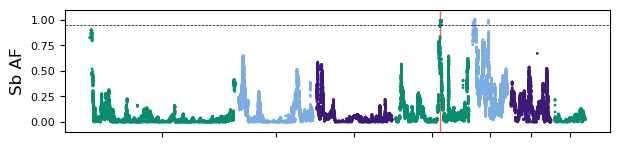

In [87]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(16*cm, 4*cm))

auto_df=df.loc[df["chrom"] != "NC_067195.1"]
               
plt.scatter((auto_df["x_start"] + auto_df["x_end"])/2, auto_df["perc_sh_nw"], s=1, color=auto_df["color"], zorder=2)


# Set the x-axis and y-axis labels
ax.set_ylabel("Sb AF", fontsize=12)
ax.tick_params(axis='y', labelsize=8)


x_ticks  = list(pos_df["mid_tick"].astype(int)[0:7])
x_labels = list(pos_df["contig"].astype(str)[0:7])


ax.set_xticks(x_ticks)
ax.set_xticklabels([])
ax.set_ylim(-0.1, 1.1)

#plot invadolysin line
invad_loc_x = offsets["NC_067199.1"] + (28_467_137+28_495_140)/2
invad_loc_x
ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)

ax.axhline(y=0.95, color='black', linestyle="dashed", linewidth=0.5)
plt.tight_layout()


plt.savefig("tmp_rfmix_perc_bovis_genome.svg")
plt.savefig("tmp_rfmix_perc_bovis_genome.png", dpi=300)

plt.show()

39477it [00:21, 1857.91it/s]
39477it [00:16, 2350.28it/s]
39477it [00:18, 2122.84it/s]


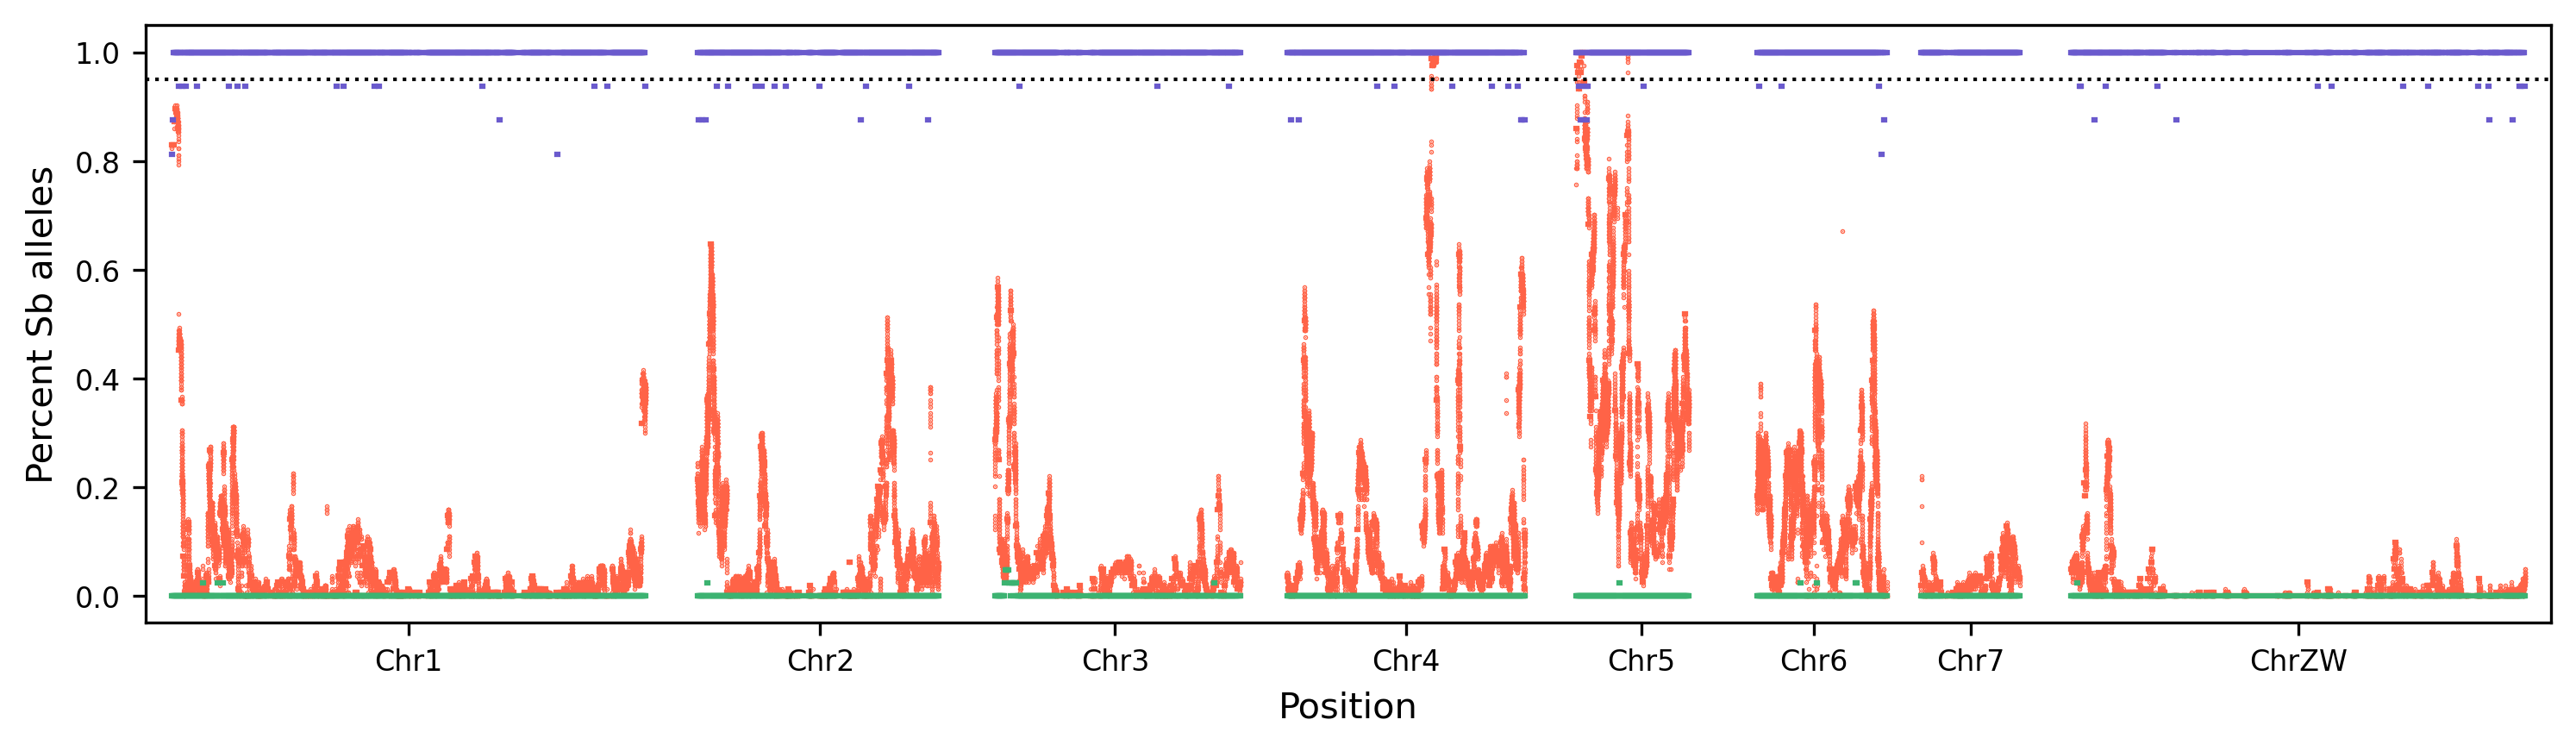

In [178]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(16*cm, 4*cm))

#x=df["x_start"]

sx=df["x_start"]
ex=df["x_end"]

plt.scatter(x, df["perc_sh_nw"], color="tomato", s=0.1, label="S. haem. (NW)")

for x1, x2, y1, y2,  in tqdm(zip(sx,ex, df["perc_sh_nw"], df["perc_sh_nw"])):
    plt.plot([x1, x2], [y1, y2], color="tomato", label="S. bovis")

for x1, x2, y1, y2,  in tqdm(zip(sx,ex, df["perc_sb"], df["perc_sb"])):
    plt.plot([x1, x2], [y1, y2], color="slateblue", label="S. bovis")

for x1, x2, y1, y2,  in tqdm(zip(sx,ex, df["perc_sh_se"], df["perc_sh_se"])):
    plt.plot([x1, x2], [y1, y2], color="mediumseagreen", label="S. bovis")

plt.axhline(0.95,  lw=1, linestyle=":", c="black")
plt.xticks(chr_ticks, chr_labels, fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([x.min()-5_000_000, x.max()+5_000_000])
#plt.tick_params(labelbottom=False, length=7) 

#plt.legend(scatterpoints=1, fontsize=10, markerscale=20)
plt.xlabel("Position")
plt.ylabel("Percent Sb alleles")
#plt.savefig("rfmix_perc_bovis_genome.svg")
#plt.savefig("rfmix_perc_bovis_genome.png", dpi=300)
plt.show()
plt.close()

### percent bovis per locus RFMIX PER POPULATION

In [10]:
rfmix_df=pd.read_csv("rfmix_df.csv")
rfmix_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,Sb_NG_au_1.2.0,Sb_NG_au_1.2.1,Sb_NG_au_2.13.0,Sb_NG_au_2.13.1,...,ssp_niger_libore_166.0,ssp_niger_libore_166.1,ssp_niger_libore_167.0,ssp_niger_libore_167.1,ssp_niger_libore_168.0,ssp_niger_libore_168.1,ssp_niger_libore_169.0,ssp_niger_libore_169.1,ssp_zambia_kafue_71.0,ssp_zambia_kafue_71.1
0,NC_067196.1,124225,212192,0.43,0.74,1302,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,NC_067196.1,212192,289797,0.74,1.01,860,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,NC_067196.1,289797,302958,1.01,1.06,645,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,NC_067196.1,302958,623463,1.06,2.17,2980,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,NC_067196.1,623463,625997,2.17,2.18,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1


In [17]:
bp_df = pd.read_csv("bp_df.csv", header=0, sep=",")
bp_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,Sb_NG_au_1.2.0,Sb_NG_au_1.2.1,Sb_NG_au_2.13.0,Sb_NG_au_2.13.1,...,ssp_niger_libore_166.0,ssp_niger_libore_166.1,ssp_niger_libore_167.0,ssp_niger_libore_167.1,ssp_niger_libore_168.0,ssp_niger_libore_168.1,ssp_niger_libore_169.0,ssp_niger_libore_169.1,ssp_zambia_kafue_71.0,ssp_zambia_kafue_71.1
0,NC_067196.1,124225,212192,0.43,0.74,1302,0,87967,0,0,...,0,0,0,0,0,0,0,0,87967,87967
1,NC_067196.1,212192,289797,0.74,1.01,860,0,77605,0,0,...,0,0,0,0,0,0,0,0,77605,77605
2,NC_067196.1,289797,302958,1.01,1.06,645,0,13161,0,0,...,0,0,0,0,0,0,0,0,13161,13161
3,NC_067196.1,302958,623463,1.06,2.17,2980,0,0,0,0,...,0,0,0,0,0,0,0,0,320505,320505
4,NC_067196.1,623463,625997,2.17,2.18,25,0,0,0,0,...,0,0,0,0,0,0,0,0,2534,2534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0,0,0,0,...,2696,2696,0,2696,2696,2696,2696,2696,2696,2696
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0,0,0,0,...,69,69,0,69,69,69,69,69,69,69
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0,0,0,0,...,1359,1359,0,1359,1359,1359,1359,1359,1359,1359
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0,0,0,0,...,647,647,0,647,647,647,647,647,647,647


In [11]:
samples=rfmix_df.columns[6:]

In [12]:
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

locations=defaultdict(lambda: [])

for hap_id in samples:
    sample  = ".".join(hap_id.split(".")[:-1])
    country = info_df.loc[info_df["sample_name"] == sample, "country"].values[0]
    species = pca_df.loc[pca_df["sample_name"] == sample, "pca_species"].values[0]
    
    if species == "s_haematobium":
        locations[country].append(hap_id)


In [13]:
# these are the locations in NW africa with more than 5 samples
target_locations = ["nigeria", "cote_d_ivoire", "niger", "sudan", "other"]

In [14]:
other_samples=[]

for hap_id in samples:
    sample = ".".join(hap_id.split(".")[:-1])

    country = info_df.loc[info_df["sample_name"] == sample, "country"].values[0]
    pop=pca_df.loc[pca_df["sample_name"] == sample, "kmeans_label"].values[0]

    if (pop == "sh_nw") & (country not in target_locations):
        other_samples.append(hap_id)
        next
    
locations["other"] = other_samples

In [18]:
#get the num sb. bp per locus per country
country_bp_df = {}
indv_sum_df = {}

row_df = bp_df.iloc[:, :6]

for location in target_locations:
    tmp_df = bp_df.loc[:, locations[location]]
    
    indv_sum_df = pd.DataFrame(tmp_df.sum(axis=0), columns=["bp_haem"])
    tmp_df = pd.concat([row_df, tmp_df], axis=1)

    country_bp_df[location]=tmp_df

In [19]:
percent_sb_per_country_per_site_df = bp_df.iloc[:, :6]

#get the percent sb per window for each country
window_sizes = bp_df["e_pos"] - bp_df["s_pos"]

country_percent_sb = {}
for location in target_locations:
    sb_percentages = 1-country_bp_df[location].iloc[:,6:].sum(axis=1)/(window_sizes*len(locations[location]))
   
    percent_sb_per_country_per_site_df[location] = sb_percentages

In [22]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb


In [23]:
x_starts = []
x_ends = []
for index, row in tqdm(percent_sb_per_country_per_site_df.iterrows()):
    chrom = row["chrom"]
    start = row["s_pos"]
    end   = row["e_pos"]
    x_start = start + x_chr_pos[chrom]
    x_end   = end + x_chr_pos[chrom]
    
    x_starts.append(x_start)
    x_ends.append(x_end)
    
percent_sb_per_country_per_site_df["x_start"] = x_starts
percent_sb_per_country_per_site_df["x_end"]  = x_ends


percent_sb_per_country_per_site_df.to_csv("percent_sb_per_country_per_site_df-2.csv", header=True, index=False, sep=",")

39477it [00:01, 28478.68it/s]


In [24]:
percent_sb_per_country_per_site_df=pd.read_csv("percent_sb_per_country_per_site_df-2.csv", sep=",")

In [25]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb

offsets=dict(zip(pos_df["contig"], pos_df["x_start"].astype(int)))
colors=dict(zip(pos_df["contig"], pos_df["color"].astype(str)))

x_start=[]
x_end=[]
c=[]

for index, row in percent_sb_per_country_per_site_df.iterrows():
    chrom = row["chrom"]
    
    offset=offsets[chrom]
    color = colors[chrom]
    
    x_start.append(row["s_pos"] + offset)
    x_end.append(row["e_pos"] + offset)

    c.append(color)
    
percent_sb_per_country_per_site_df["x_start"] = x_start
percent_sb_per_country_per_site_df["x_end"] = x_end
percent_sb_per_country_per_site_df["color"] = c

percent_sb_per_country_per_site_df.to_csv(f"percent_sb_per_country_per_site_df-2.csv", header=True, sep=",", index=False)
percent_sb_per_country_per_site_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,nigeria,cote_d_ivoire,niger,sudan,other,x_start,x_end,color
0,NC_067196.1,124225,212192,0.43,0.74,1302,0.833333,0.523810,0.986486,1.000000,0.666667,124225,212192,#078d70
1,NC_067196.1,212192,289797,0.74,1.01,860,0.833333,0.523810,1.000000,1.000000,0.666667,212192,289797,#078d70
2,NC_067196.1,289797,302958,1.01,1.06,645,0.833333,0.523810,1.000000,1.000000,0.666667,289797,302958,#078d70
3,NC_067196.1,302958,623463,1.06,2.17,2980,0.833333,0.523810,1.000000,1.000000,0.666667,302958,623463,#078d70
4,NC_067196.1,623463,625997,2.17,2.18,25,0.833333,0.523810,1.000000,1.000000,0.666667,623463,625997,#078d70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0.083333,0.142857,0.094595,0.055556,0.222222,243261000,243263696,#078d70
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0.083333,0.095238,0.094595,0.055556,0.222222,243263696,243263765,#078d70
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0.083333,0.119048,0.094595,0.055556,0.222222,243263765,243265124,#078d70
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0.083333,0.119048,0.094595,0.111111,0.222222,243265124,243265771,#078d70


In [26]:
for location in ["nigeria", "cote_d_ivoire", "niger", "sudan", "other"]:
    perc = (percent_sb_per_country_per_site_df["n_snps"] * percent_sb_per_country_per_site_df[location]).sum()/percent_sb_per_country_per_site_df["n_snps"].sum()
    print(f"{location}\t{perc}")

nigeria	0.11361744166913261
cote_d_ivoire	0.0800064024375502
niger	0.06766153877402353
sudan	0.04702941057978587
other	0.05752440208792402


In [189]:
#plot everything in one figure
figure(figsize=(12, 3), dpi=300)

x=percent_sb_per_country_per_site_df["x_start"]

sx=percent_sb_per_country_per_site_df["x_start"]
ex=percent_sb_per_country_per_site_df["x_end"]

colors={ "niger": "tomato",
         "nigeria": "goldenrod",
         "sudan": "dodgerblue",
         "cote_d_ivoire": "orchid",
         "other": "grey"}

for country in target_locations:
    for x1, x2, y,  in tqdm(zip(sx,ex, percent_sb_per_country_per_site_df[country])):
        plt.plot([x1, x2], [y, y], color=colors[country], label=country, markersize=10)


plt.axhline(0.95,  lw=1, linestyle=":", c="black")
plt.xticks(chr_ticks, chr_labels, fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([x.min()-5_000_000, x.max()+5_000_000])
#plt.tick_params(labelbottom=False, length=7) 

#plt.legend(scatterpoints=1, fontsize=10, markerscale=20, loc='upper right')
plt.xlabel("Position")
plt.ylabel("Percent Sb alleles")
#plt.savefig("rfmix_perc_bovis_genome_by_country.svg")
plt.savefig("rfmix_perc_bovis_genome_by_country.png", dpi=300)
plt.close()

39477it [00:20, 1909.13it/s]
39477it [00:18, 2152.19it/s]
39477it [00:18, 2159.40it/s]
39477it [00:17, 2292.61it/s]
39477it [00:17, 2260.43it/s]


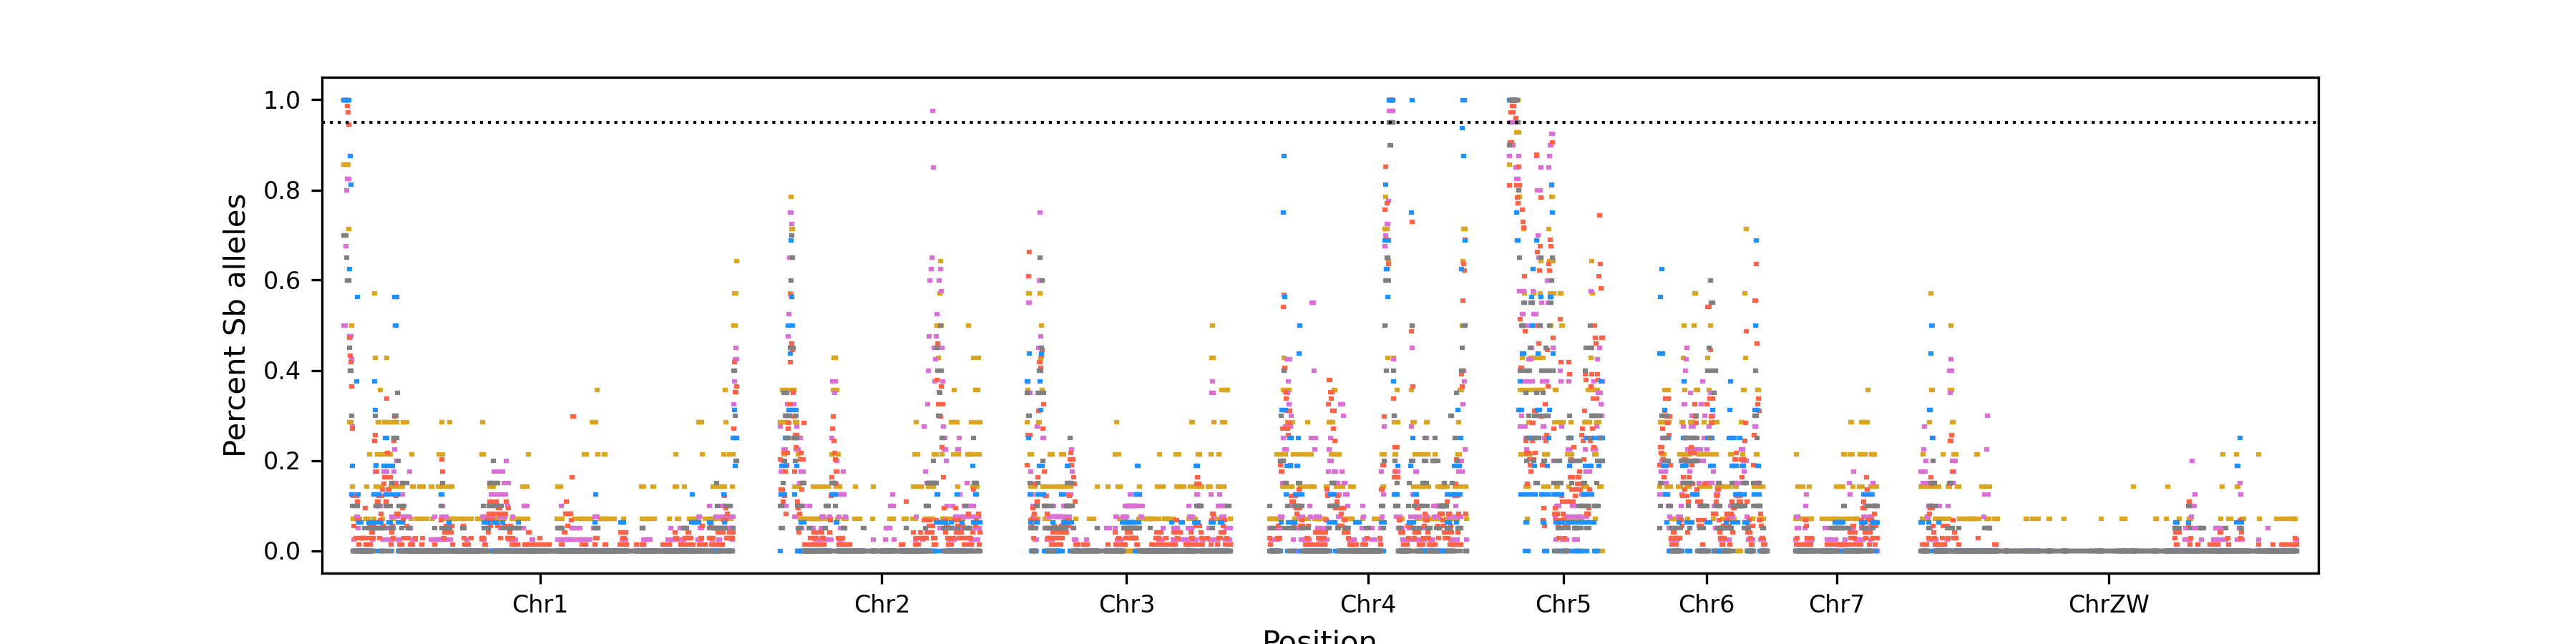

In [190]:
Image("rfmix_perc_bovis_genome_by_country.png")

### How similar are introgression patterns in NW

In [76]:
percent_sb_per_country_per_site_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,nigeria,cote_d_ivoire,niger,sudan,other,x_start,x_end
0,NC_067196.1,124225,212192,0.43,0.74,1302,0.857143,0.500,0.986486,1.0000,0.70,124225.0,212192.0
1,NC_067196.1,212192,289797,0.74,1.01,860,0.857143,0.500,1.000000,1.0000,0.70,212192.0,289797.0
2,NC_067196.1,289797,302958,1.01,1.06,645,0.857143,0.500,1.000000,1.0000,0.70,289797.0,302958.0
3,NC_067196.1,302958,623463,1.06,2.17,2980,0.857143,0.500,1.000000,1.0000,0.70,302958.0,623463.0
4,NC_067196.1,623463,625997,2.17,2.18,25,0.857143,0.500,1.000000,1.0000,0.70,623463.0,625997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0.071429,0.125,0.094595,0.0625,0.25,265761000.0,265763696.0
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0.071429,0.075,0.094595,0.0625,0.25,265763696.0,265763765.0
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0.071429,0.100,0.094595,0.0625,0.25,265763765.0,265765124.0
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0.071429,0.100,0.094595,0.1250,0.25,265765124.0,265765771.0


In [81]:
colors

{'angola': '#FF0000',
 'swaziland': '#FF1C00',
 'ethiopia': '#FF3800',
 'kenya': '#FF5500',
 'madagascar': '#FF7100',
 'namibia': '#FF8D00',
 'tanzania': '#FFAA00',
 'uganda': '#FFC600',
 'zambia': '#FFE200',
 'zanzibar': '#FFFF00',
 'cameroon': '#0000FF',
 'cote_d_ivoire': '#0019E5',
 'egypt': '#0033CC',
 'gambia': '#004CB2',
 'guineabissau': '#006699',
 'liberia': '#007F7F',
 'mali': '#009965',
 'niger': '#00B24C',
 'nigeria': '#00CC32',
 'senegal': '#00E519',
 'sudan': '#00FF00',
 'na': '#808080'}

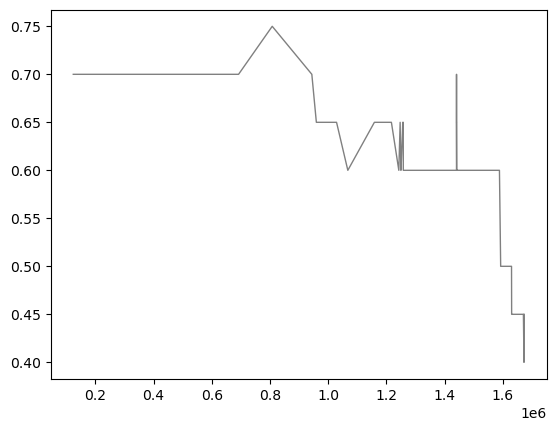

In [98]:
plt.plot(sx[:100], percent_sb_per_country_per_site_df[country][:100], color='grey', lw=1)
plt.plot(x1, y, color=c, label=country, marker=".", markersize=1, zorder=2)
    
plt.show()

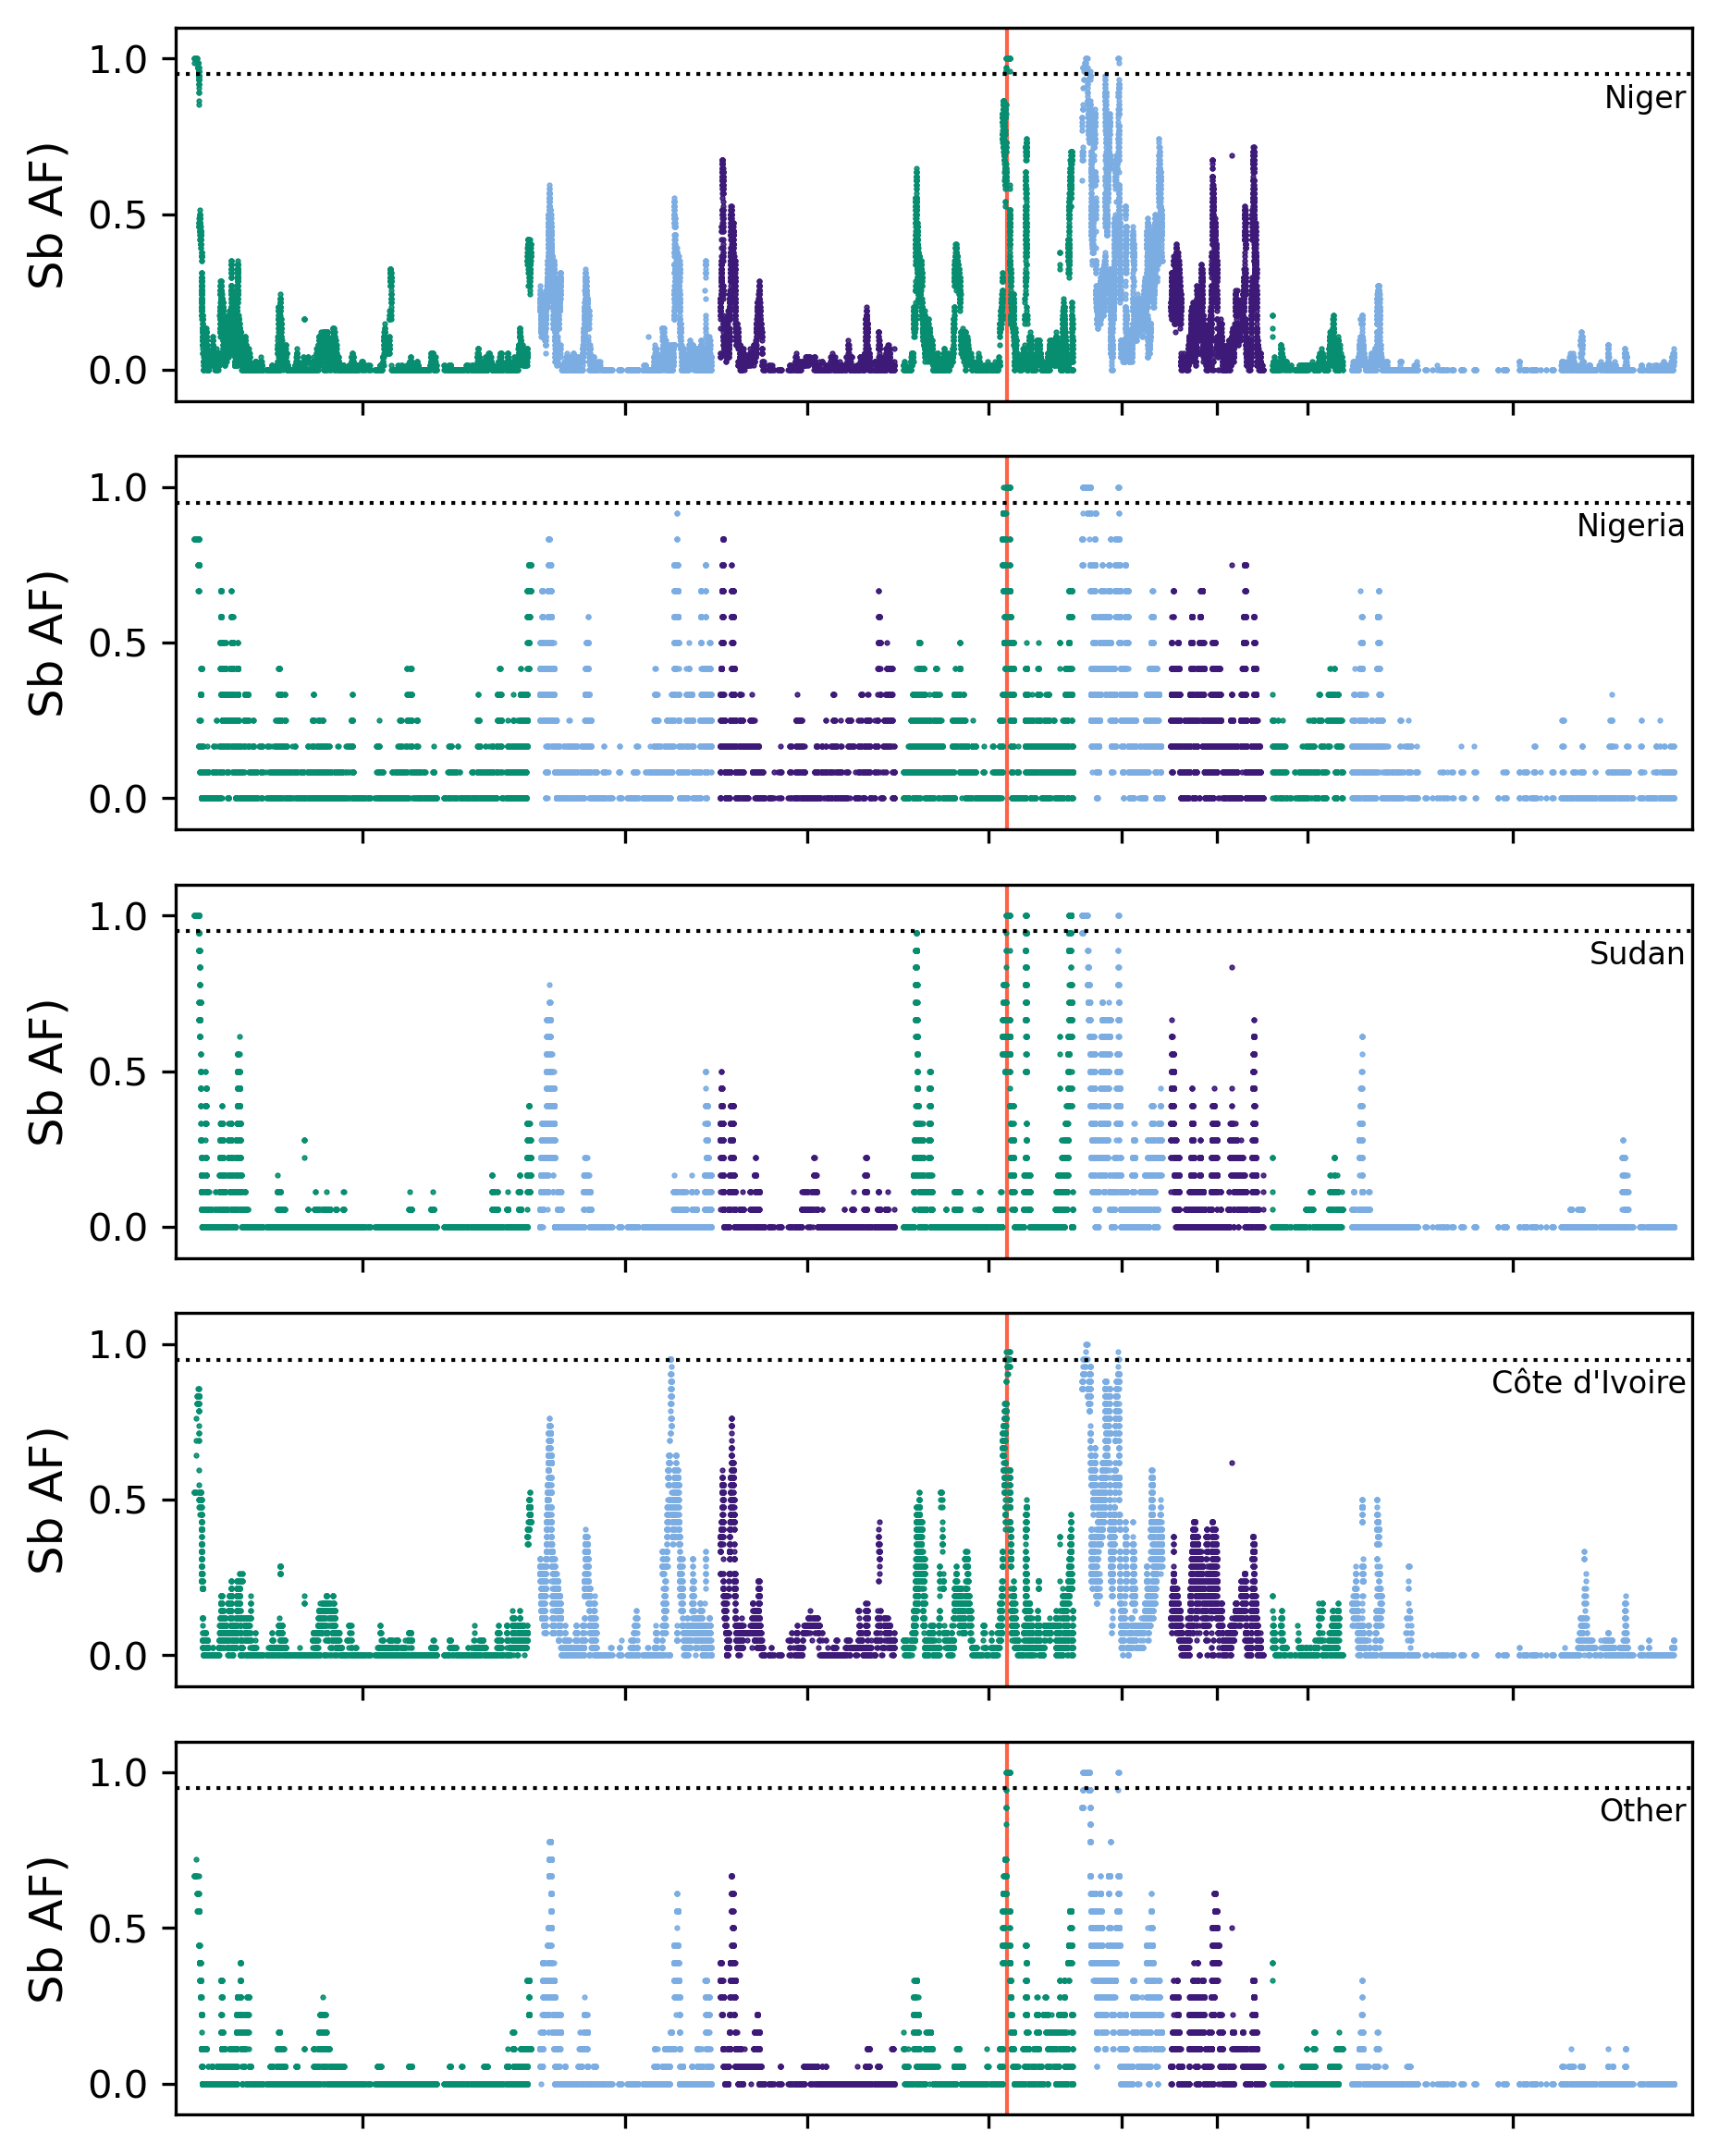

In [27]:
# Sample data
target_locations = ["niger", "nigeria", "sudan", "cote_d_ivoire", "other"]

col_df=pd.read_csv(f"{proj_dir}/data/country_colors.csv", sep=",", header=0)
colors = col_df.set_index('country')['color'].to_dict()

labels = {
    "niger": "Niger",
    "nigeria": "Nigeria",
    "sudan": "Sudan",
    "cote_d_ivoire": "Côte d'Ivoire",
    "other": "Other"
}
x = percent_sb_per_country_per_site_df["x_start"]
sx = percent_sb_per_country_per_site_df["x_start"]
ex = percent_sb_per_country_per_site_df["x_end"]

# Create a figure with multiple subplots (one per country)
cm = 1/2.54
fig, axes = plt.subplots(nrows=len(target_locations), 
                         figsize=(16*cm, 4*len(target_locations)*cm), 
                         dpi=300)

#loop through the countries and plot each in a sub plot
for country, ax in zip(target_locations, axes):
   
    #plot the actual data points
    for x1, x2, y, c in zip(sx, ex, percent_sb_per_country_per_site_df[country], percent_sb_per_country_per_site_df["color"]):
        ax.plot(x1, y, color=c, label=country, marker=".", markersize=1, zorder=2, lw=1)

    #format the x axis
    x_ticks  = list(pos_df["mid_tick"].astype(int)[0:8])
    x_labels = list(pos_df["contig"].astype(str)[0:8])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([])
    
    #format the y axis 
    ax.set_ylabel(f"Sb AF)", fontsize=12)
 
    #set the limits of the figure
    ax.set_xlim([x.min()-5_000_000, x.max()+5_000_000])
    ax.set_ylim(-0.1, 1.1)

    #plot line at 95% allele frequency
    ax.axhline(0.95, lw=1, linestyle=":", c="black")
        
    #plot invadolysin line
    invad_loc_x = offsets["NC_067199.1"] + (28_467_137+28_495_140)/2
    ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)

    # Add the country name to each subplot at specified coordinates
    ax.text(percent_sb_per_country_per_site_df["x_end"].max()+3_500_000, 0.92, labels[country], fontsize=8, ha='right', va='top')

# Save the combined figure
fig.tight_layout()
fig.savefig("rfmix_perc_bovis_genome_by_individual_country-2.png", dpi=300)

plt.show()


### Can we calculate statistical correlations (R)?

In [29]:
combos=list(itertools.combinations(target_locations, 2))

In [31]:
data = []

for pop1, pop2 in combos:
    slope, intercept, r_value, p_value, se, = linregress(percent_sb_per_country_per_site_df[pop1], percent_sb_per_country_per_site_df[pop2])
    data.append([pop1, pop2, slope, intercept, r_value, p_value, se])

r_df = pd.DataFrame(data, columns=['pop1', 'pop2', 'slope', 'intercept', 'r', 'p', 'se'])

# Save to CSV
r_df.to_csv('introgression_correlations.csv', index=False)
r_df

,pop1,pop2,slope,intercept,r,p,se
0,niger,nigeria,0.716873,0.105478,0.673435,0.0,0.003961
1,niger,sudan,0.740924,0.001127,0.743270,0.0,0.003356
2,niger,cote_d_ivoire,0.817005,0.049265,0.794836,0.0,0.003139
3,niger,other,0.711158,0.021425,0.766167,0.0,0.003002
4,nigeria,sudan,0.549200,0.008024,0.586475,0.0,0.003818
5,nigeria,cote_d_ivoire,0.661107,0.043585,0.684654,0.0,0.003542
6,nigeria,other,0.572258,0.017247,0.656290,0.0,0.003311
7,sudan,cote_d_ivoire,0.634571,0.113304,0.615404,0.0,0.004091
8,sudan,other,0.639967,0.064951,0.687293,0.0,0.003404
9,cote_d_ivoire,other,0.695184,0.013911,0.769848,0.0,0.002901


In [32]:
r_df = pd.read_csv('introgression_correlations.csv', sep=",")
percent_sb_per_country_per_site_df = pd.read_csv("percent_sb_per_country_per_site_df.csv", sep=",")

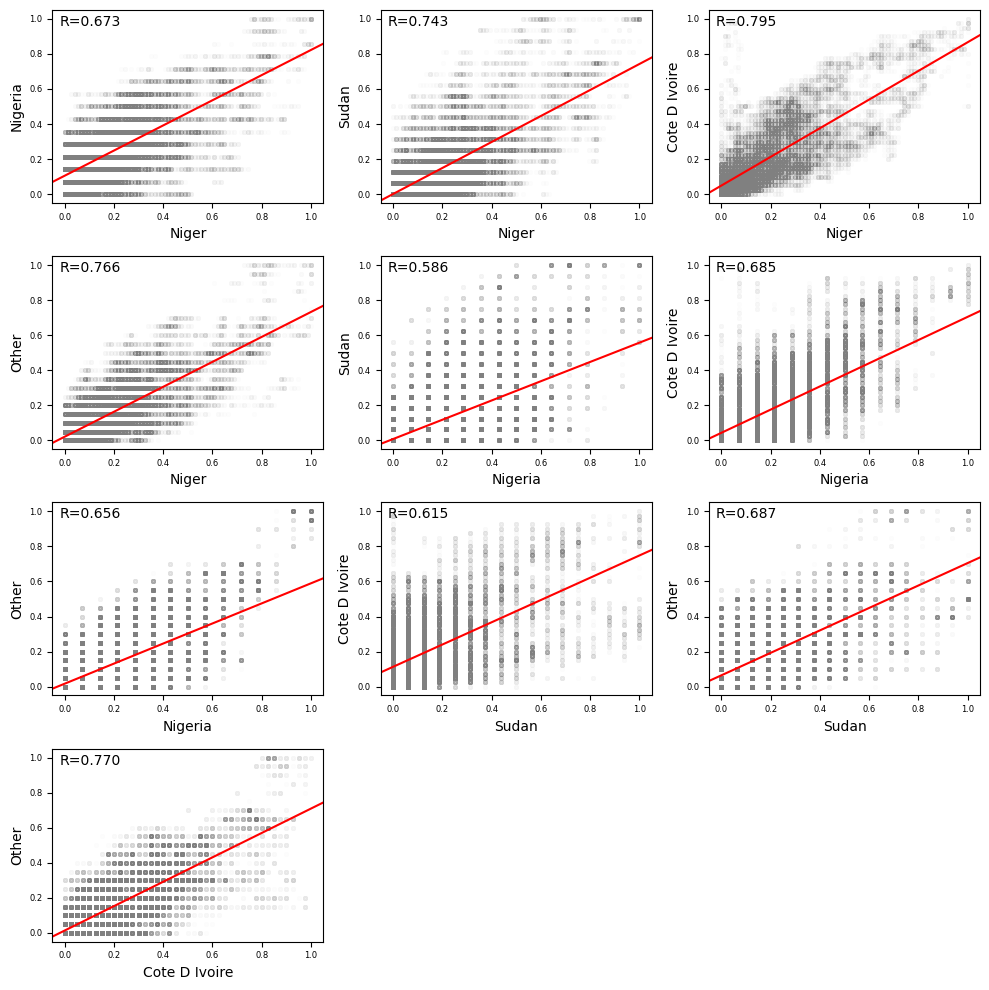

In [33]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))

# Flatten the array of Axes objects into 1D for easy iteration
axs = axs.flatten()

# Create scatter plots in the first 10 subplots
for i in range(0, len(combos)):
    pop1, pop2 = combos[i]
    
    pop1_x=percent_sb_per_country_per_site_df[pop1]
    pop2_y=percent_sb_per_country_per_site_df[pop2]
    slope=r_df.iloc[i]["slope"]
    intercept=r_df.iloc[i]["intercept"]
    r=r_df.iloc[i]["r"]

    axs[i].scatter(pop1_x, pop2_y, alpha=0.01, c="grey", s=8)
    axs[i].axline(xy1=(0, intercept), slope=slope, color='r')
    
    axs[i].set_xlabel(pop1.replace("_", " ").title())
    axs[i].set_ylabel(pop2.replace("_", " ").title())
    axs[i].tick_params(axis='both', which='major', labelsize=6)
    axs[i].set_ylim([-0.05,1.05])
    axs[i].set_xlim([-0.05,1.05])
    #axs[i].set_xticks(np.arange(0, 1.05, 0.05))
    #axs[i].set_yticks(np.arange(0, 1.05, 0.05))
    
     # Add the text to the top left corner of each subplot
    axs[i].text(0.025, 0.975, f"R={r:.3f}", va='top', ha='left', transform=axs[i].transAxes)
    
# Hide the last two subplots
for i in range(10, 12):
    axs[i].axis('off')

plt.tight_layout()

plt.savefig("introgression_correlations_by_country.svg")
plt.savefig("introgression_correlations_by_country.png", dpi=300)

plt.show()